# Photon correlation spectroscopy development
### M. L. Whittaker 
### 26 June 2025

In [195]:
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import RANSACRegressor

%load_ext autoreload
%autoreload 2
import pct

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
path = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/PCT/Data/LiTFSI'
pct = importlib.reload(pct)
loader = pct.Dataloader(path)
data = loader.load()
analyzer = loader.Analyzer()

## SLS

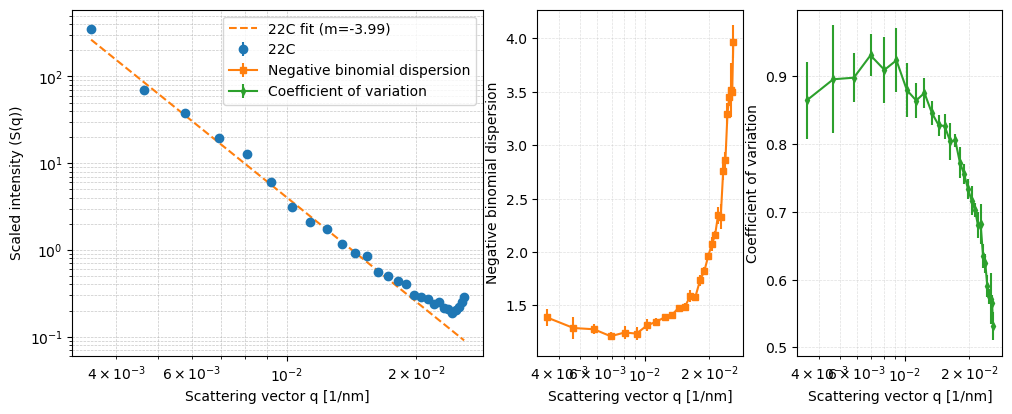

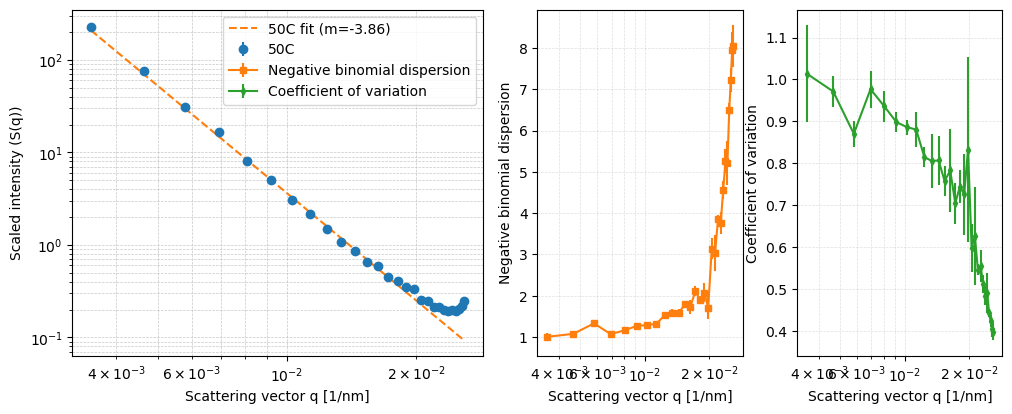

In [252]:
# first dataset
sq_I1, sq_err1, q1, nb_scale1, nb_scale_err1, cv_mean1, cv_std1 = analyzer.sq(data, sample='20m', experiment="22C")
fit1 = analyzer.sq_fit(q1, sq_I1, intensity_err=sq_err1, q_range=(4e-3, 2e-2))
axes1 = analyzer.plot_sq(
    q1,
    sq_I1,
    intensity_err=sq_err1,
    label="22C",
    logx=True,
    logy=True,
    scale_parameters=nb_scale1,
    scale_err=nb_scale_err1,
    cv_parameters=cv_mean1,
    cv_err=cv_std1,
    fit=fit1,
)

# second dataset on the same axes
sq_I2, sq_err2, q2, nb_scale2, nb_scale_err2, cv_mean2, cv_std2 = analyzer.sq(data, sample='20m', experiment="50C")
fit2 = analyzer.sq_fit(q2, sq_I2, intensity_err=sq_err2, q_range=(4e-3, 2e-2))
axes2 = analyzer.plot_sq(
    q2,
    sq_I2,
    intensity_err=sq_err2,
    label="50C",
    logx=True,
    logy=True,
    scale_parameters=nb_scale2,
    scale_err=nb_scale_err2,
    cv_parameters=cv_mean2,
    cv_err=cv_std2,
    fit=fit2,
)

sq_plot = fig
plt.savefig("/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/PCT/Data/LiTFSI/20m/images/sq_plot.png", dpi=300)
plt.show()


In [253]:
wavelets = analyzer.trace(data, sample="20m", experiment="22C", measurement=25, signal_column=["CR CHA [kHz]"])

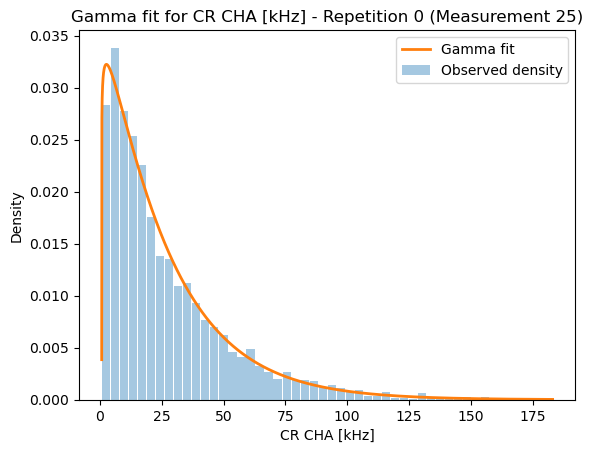

In [254]:
fit = analyzer.fit_gamma_trace(wavelets, measurement=25,
                               repetition="Repetition 0",
                               signal_column="CR CHA [kHz]",
                               )

fit_plot = analyzer.plot_gamma_fit(wavelets,
                                   measurement=25,
                                   repetition="Repetition 0",
                                   signal_column="CR CHA [kHz]",
                                   fit_results=fit)

## DLS

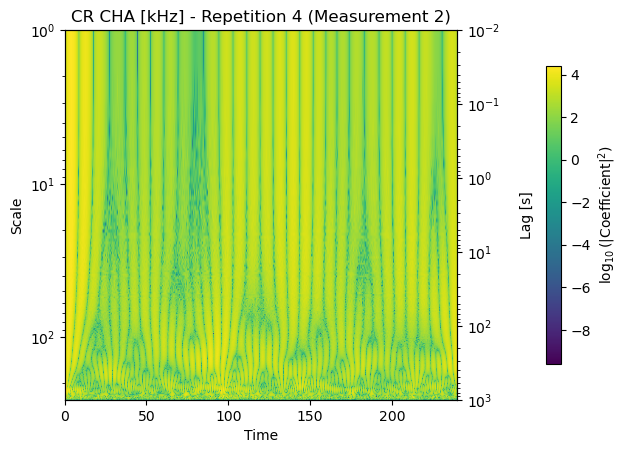

In [ ]:
lags = analyzer.trace_lags(wavelets, measurement=2, repetition=4, concatenate=False)

lag_plot = analyzer.plot_wavelet(wavelets, 
                      measurement=2, 
                      repetition=4,
                      signal_column="CR CHA [kHz]",
                      concatenate=False, 
                      lag_results=lags)

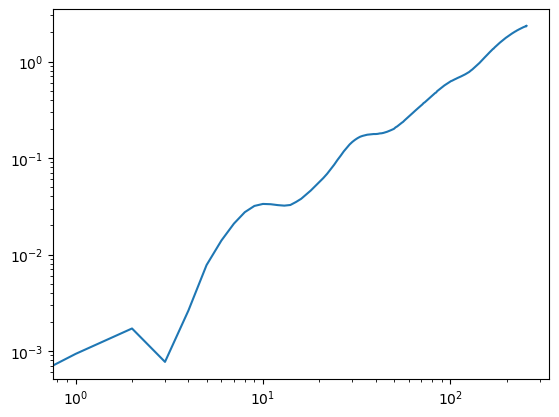

In [160]:
plt.plot(np.mean(wavelets[2]['Repetition 0']['CR CHA [kHz]']['coefficients'], axis=1))
plt.xscale('log')
plt.yscale('log')

In [53]:
path2 = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/LDRD_FY25/data/SISV_1%/18.5C/Measurement 84/Repetition 4/Count Trace.csv'

In [54]:
data = pd.read_csv(path2, skiprows=2)

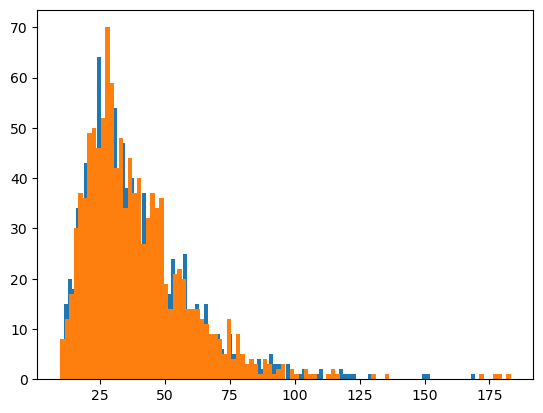

In [55]:
plt.hist(data['CR CHA [kHz]'], bins=100)
plt.hist(data['CR CHB [kHz]'], bins=100); plt.show()

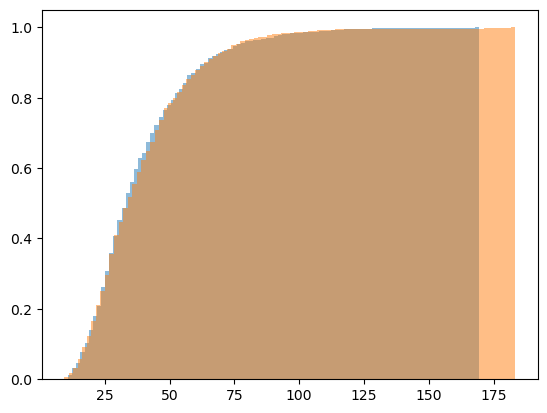

In [62]:
plt.hist(data['CR CHA [kHz]'], bins=100, cumulative=True, density=True, alpha=0.5)
plt.hist(data['CR CHB [kHz]'], bins=100, cumulative=True, density=True, alpha=0.5); plt.show()

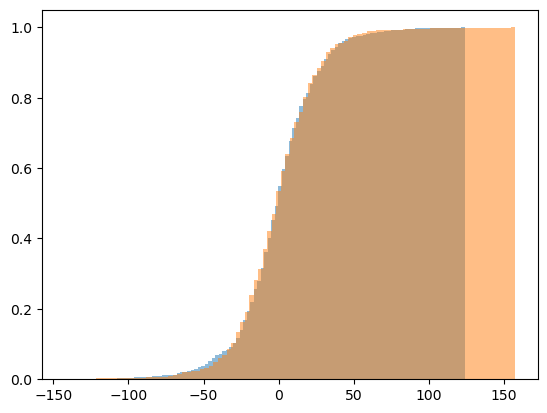

In [63]:
plt.hist(np.diff(data['CR CHA [kHz]']), bins=100, cumulative=True, density=True, alpha=0.5)
plt.hist(np.diff(data['CR CHB [kHz]']), bins=100, cumulative=True, density=True, alpha=0.5); 
plt.show()

In [29]:
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp
from scipy.stats import shapiro

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(data['CR CHA [kHz]'], data['CR CHB [kHz]'])

# Perform the Anderson-Darling test
result = shapiro(data['CR CHA [kHz]'])

# Output results
print(f'Kolmogorov-Smirnov statistic: {ks_statistic:.4f}')
print(f'p-value: {p_value:.4e}')

# Output results
print(f'Shapiro-Wilk statistic: {result.statistic:.4f}')
print(f'p-value: {result.pvalue:.4e}')

Kolmogorov-Smirnov statistic: 0.0377
p-value: 3.9213e-01
Shapiro-Wilk statistic: 0.8733
p-value: 1.9766e-29


In [34]:
data = data[['CR CHA [kHz]', 'CR CHB [kHz]']].values

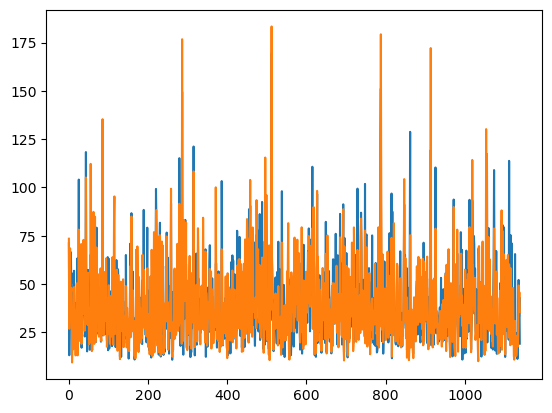

In [ ]:
plt.plot(data['CR CHA [kHz]'])
plt.plot(data['CR CHB [kHz]']); plt.show()

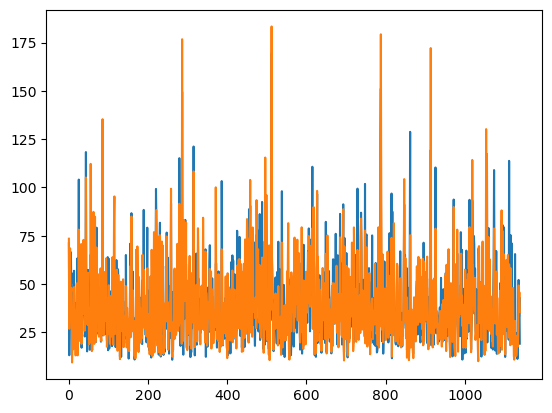

In [ ]:
plt.plot(data['CR CHA [kHz]'])
plt.plot(data['CR CHB [kHz]']); plt.show()

In [50]:
bic_min = np.inf
for i in range(6):
    gmm = GaussianMixture(random_state=42, n_components=i+1)
    gmm_data = gmm.fit(data.reshape(-1,1))
    
    bic = gmm_data.bic(data[:,0].reshape(-1,1))
    aic = gmm_data.aic(data[:,0].reshape(-1,1))
    
    if aic < bic_min:
        gmm_min = i+1
        gmm_data_min = gmm_data

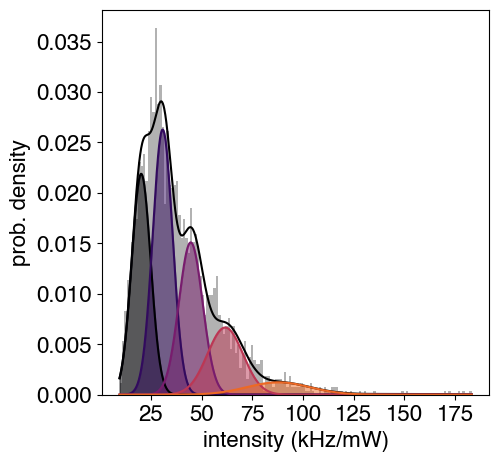

In [51]:
fig = plt.figure(figsize=(5,5))

# Generate x-axis for plotting PDFs
x = np.linspace(data.min(), data.max(), 1024).reshape(-1, 1) 

# Compute the weighted sum of component PDFs
logprob = gmm_data_min.score_samples(x)
pdf = np.exp(logprob)

# Individual component PDFs
responsibilities = gmm_data_min.predict_proba(x)
component_pdfs = responsibilities * pdf[:, np.newaxis]
sort_order = np.argsort(gmm_data_min.means_.T[0])
component_pdfs = component_pdfs[:,sort_order]


# Plot histogram of data
plt.hist(data[data>0].ravel().reshape(-1,1), bins=150, density=True, alpha=0.6, color='gray', label='data')

# Plot GMM overall PDF
plt.plot(x, pdf, '-k', label='fit')

# Plot each individual Gaussian component
for i in range(gmm_min-1):
    color = plt.cm.inferno(i / gmm_min)
    plt.plot(x[:,0], component_pdfs[:, i], color=color, label=f'C{i+1}')
    plt.fill_between(x.ravel(), component_pdfs[:, i], color=color, alpha=0.5)

# plt.legend()
axes_font = {'fontname':'Helvetica', 'size':'16', 'color':'black'}
plt.xlabel('intensity (kHz/mW)', **axes_font)
plt.xticks(**axes_font)
plt.ylabel('prob. density', **axes_font)
plt.yticks(**axes_font)
plt.show()

In [18]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
tdata = power.fit_transform(data)

In [19]:
power.lambdas_

array([-0.16839364, -0.10746185])

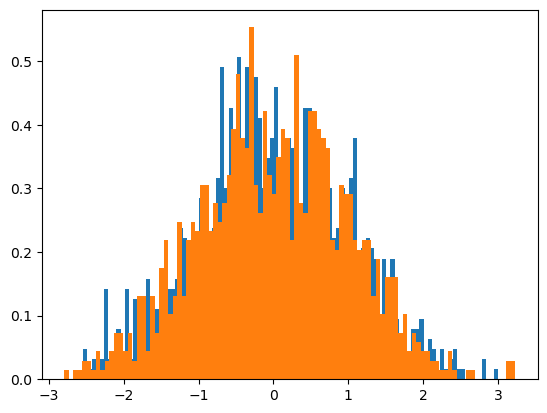

In [20]:
plt.hist(tdata[:,0], bins=100, density=True)
plt.hist(tdata[:,1], bins=100, density=True); plt.show()

In [21]:
# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(tdata[:,0], tdata[:,1])

# Perform the Anderson-Darling test
result = shapiro([tdata[:,0]])

# Output results
print(f'Kolmogorov-Smirnov statistic: {ks_statistic:.4f}')
print(f'p-value: {p_value:.4e}')

# Output results
print(f'Shapio-Wilk statistic: {result.statistic:.4f}')
print(f'p-value: {result.pvalue:.4e}')

Kolmogorov-Smirnov statistic: 0.0219
p-value: 9.4699e-01
Shapio-Wilk statistic: 0.9975
p-value: 7.6764e-02


In [22]:
for i in range(3):
    gmm = GaussianMixture(random_state=42, n_components=i+1)
    gmm_data = gmm.fit(tdata[:,0].reshape(-1,1))
    print(f'bic_{i+1}: {gmm_data.bic(tdata[:,0].reshape(-1,1))}')
    print(f'aic_{i+1}: {gmm_data.aic(tdata[:,0].reshape(-1,1))}')

bic_1: 3249.2574227900004
aic_1: 3239.1798557072234
bic_2: 3269.911061560048
aic_2: 3244.7171438531054
bic_3: 3286.1217878519133
aic_3: 3245.8115195208047


In [23]:
print(gmm_data.means_)
print(gmm_data.covariances_)

[[-0.17290772]
 [ 1.01426917]
 [-1.29494364]]
[[[0.23912036]]

 [[0.3721075 ]]

 [[0.3156094 ]]]


counts/second * photons/count * seconds = photons/second

((y+1)**l - 1) / l

In [13]:
savedir = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/LDRD_FY25/images/'

In [17]:
def line(x, m, b):
    return m * x + b

def exp(x, a, b, c):
    return a * np.exp(-b * x) + c

In [139]:
path_to_all = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/LDRD_FY25/data/SISV_1%/'
pct1 = pct.Dataloader(path_to_all)
pct_data = pct1.load()
temps = list(pct_data.samples.keys())

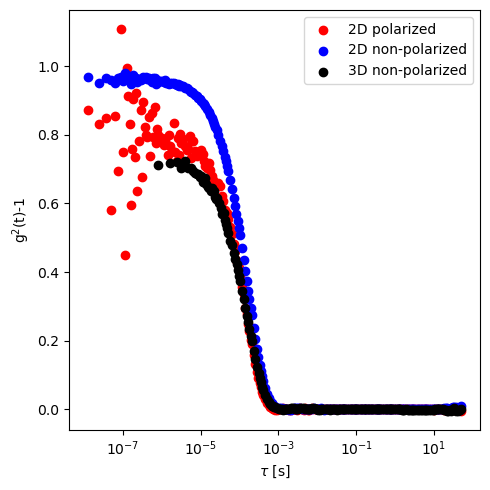

In [473]:
cf_data = pct_data.samples[temp]['experiments']['Measurement 1']['measurements'][0]['repetitions']['Correlation Function.csv']
cf_data2 = pct_data.samples[temp]['experiments']['Measurement 2']['measurements'][0]['repetitions']['Correlation Function.csv']
cf_data3 = pct_data.samples[temp]['experiments']['Measurement 3']['measurements'][0]['repetitions']['Correlation Function.csv']

plt.figure(figsize=(5, 5))
plt.scatter(cf_data['Lag time [s]'], cf_data['Value'], color='r', label='2D polarized')
plt.scatter(cf_data2['Lag time [s]'], cf_data2['Value'], color='b', label='2D non-polarized')
plt.scatter(cf_data3['Lag time [s]'], cf_data3['Value'], color='k', label='3D non-polarized')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\tau$ [s]')
plt.ylabel('g$^{2}$(t)-1')
plt.legend()
plt.tight_layout()

plt.savefig(savedir + "SISV_corrfun_example.png")
plt.show()

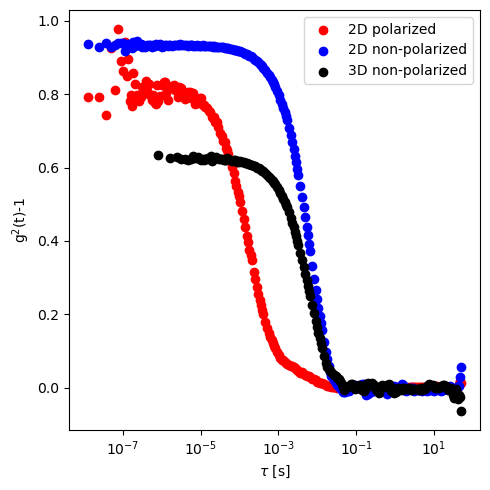

In [476]:
cf_data = pct_data.samples[temp]['experiments']['Measurement 82']['measurements'][0]['repetitions']['Correlation Function.csv']
cf_data2 = pct_data.samples[temp]['experiments']['Measurement 83']['measurements'][0]['repetitions']['Correlation Function.csv']
cf_data3 = pct_data.samples[temp]['experiments']['Measurement 84']['measurements'][0]['repetitions']['Correlation Function.csv']

plt.figure(figsize=(5, 5))
plt.scatter(cf_data['Lag time [s]'], cf_data['Value'], color='r', label='2D polarized')
plt.scatter(cf_data2['Lag time [s]'], cf_data2['Value'], color='b', label='2D non-polarized')
plt.scatter(cf_data3['Lag time [s]'], cf_data3['Value'], color='k', label='3D non-polarized')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\tau$ [s]')
plt.ylabel('g$^{2}$(t)-1')
plt.legend()
plt.tight_layout()

plt.savefig(savedir + "SISV_corrfun_example.png")
plt.show()

In [ ]:
temp = temps[0]
keys = pct_data.samples[temp]['experiments'].keys()
keys_isotropic = np.array(list(keys))[2::3]
keys_polarized = np.array(list(keys))[::3]

ct = np.ones((len(keys_isotropic), 5, 2))
ct_pol = np.ones((len(keys_polarized), 5, 2))

for i, k in enumerate(keys_isotropic):
    for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
        gamma = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['Count Trace.csv']
        
        gamma_nan = np.argmax(pd.isnull(gamma))
        gamma_lim = np.min((gamma_nan,2))
        gammas[i, ii,  :] = gamma[:gamma_lim]


for i, k in enumerate(keys_polarized):
    for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
        gamma_pol = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
        
        gamma_pol_nan = np.argmax(pd.isnull(gamma_pol))
        gamma_lim = np.min((gamma_nan,2))
        gammas_pol[i, ii,  :] = gamma_pol[:gamma_lim]

dict_keys(['11.5C', '15C', '18.5C', '22C', '25.5C', '28C', '30.5C'])

In [140]:
path11C = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/LDRD_FY25/data/SISV_1%/11.5C'
data11C= pd.read_csv(path11C + '/SISV_1%_11.5C.csv', skiprows=3)

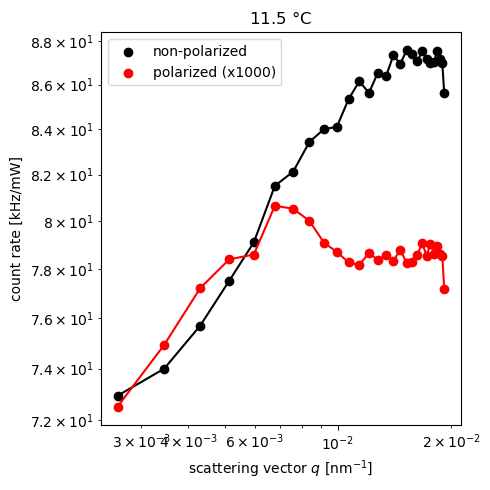

In [172]:
subset_11C_1 = data11C[::3]
subset_11C_2 = data11C[2::3]
correction = np.ones(len(subset_11C_1)) * 1400
angles = 4 * np.pi * (1/632.8) * np.sin(np.deg2rad(subset_11C_1['Scattering angle [deg]'])/2)
# subset1_popt, subset1_pcov = curve_fit(exp, angles[-3::], (subset1['Scaled count rate [kHz/mW]'] * correction)[-3::], p0=[1,1,1])

fig = plt.figure(figsize=(5, 5))
plt.scatter(angles, subset_11C_2['Scaled count rate [kHz/mW]'], color='k', label='non-polarized')
plt.plot(angles, subset_11C_2['Scaled count rate [kHz/mW]'], color='k')

plt.scatter(angles, subset_11C_1['Scaled count rate [kHz/mW]']*correction, color='r', label='polarized (x1000)')
plt.plot(angles, subset_11C_1['Scaled count rate [kHz/mW]']*correction, color='r')

plt.xlabel('scattering vector $q$ [nm$^{-1}$]')
plt.xscale('log')
plt.ylabel('count rate [kHz/mW]')
plt.yscale('log')
plt.legend()
plt.title(r'11.5 $\degree$C')
plt.tight_layout()

plt.savefig(savedir + "SISV_guinier_11C.png")
plt.show()

In [142]:
temp = temps[0]
keys = pct_data.samples[temp]['experiments'].keys()
keys_isotropic = np.array(list(keys))[2::3]
keys_polarized = np.array(list(keys))[::3]

gammas = np.ones((len(keys_isotropic), 5, 2))
gammas_pol = np.ones((len(keys_polarized), 5, 2))

for i, k in enumerate(keys_isotropic):
    for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
        gamma = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
        
        gamma_nan = np.argmax(pd.isnull(gamma))
        gamma_lim = np.min((gamma_nan,2))
        gammas[i, ii,  :] = gamma[:gamma_lim]


for i, k in enumerate(keys_polarized):
    for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
        gamma_pol = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
        
        gamma_pol_nan = np.argmax(pd.isnull(gamma_pol))
        gamma_lim = np.min((gamma_nan,2))
        gammas_pol[i, ii,  :] = gamma_pol[:gamma_lim]

In [143]:
g_mean = np.mean(np.sort(gammas, axis=-1), axis=1)
g_pol_mean = np.mean(np.sort(gammas_pol, axis=-1), axis=1)
g_std = np.std(np.sort(gammas, axis=-1), axis=1)
g_pol_std = np.std(np.sort(gammas_pol, axis=-1), axis=1)

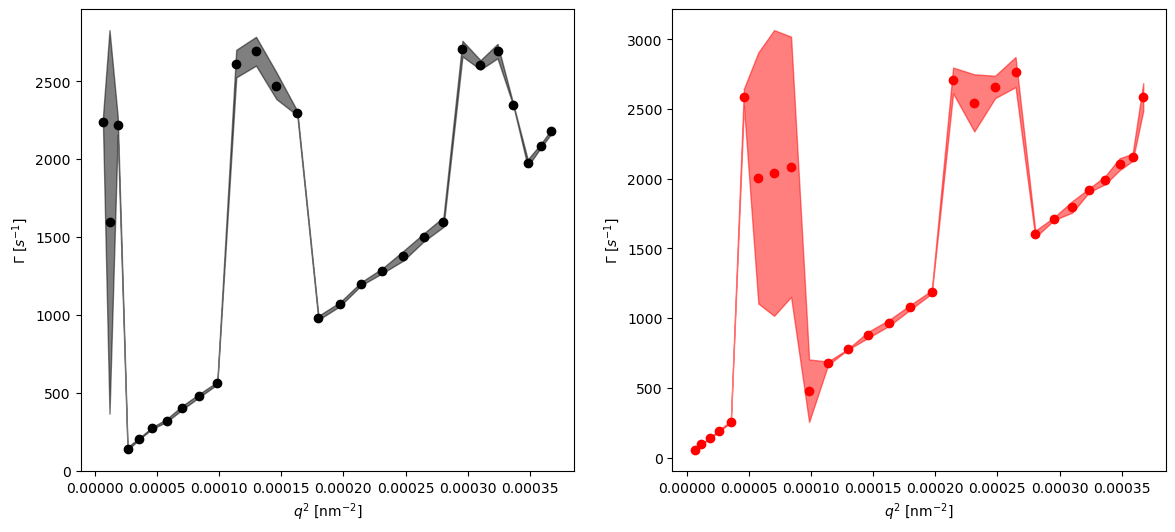

In [144]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
ax1, ax2 = axs

ax1.scatter((angles**2), g_mean[:,0], color='k')
ax1.fill_between(angles**2, g_mean[:,0] - g_std[:,0], g_mean[:,0] + g_std[:,0], color='k', alpha=0.5)
ax1.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax1.set_ylabel(r'$\Gamma$ [$s^{-1}]$')

ax2.scatter(angles**2, g_pol_mean[:,0], color='r')
ax2.fill_between(angles**2, g_pol_mean[:,0] - g_pol_std[:,0], g_pol_mean[:,0] + g_pol_std[:,0], color='r', alpha=0.5)
ax2.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax2.set_ylabel(r'$\Gamma$ [$s^{-1}]$')

plt.show()

In [145]:
idxs = np.ones(len(angles), dtype=bool)
idxs_pol = np.ones(len(angles), dtype=bool)

ransac11C = RANSACRegressor()
ransac11C_pol = RANSACRegressor()
ransac11C.fit(np.array(angles**2).reshape(-1, 1), g_mean[:, 0])
ransac11C_pol.fit(np.array(angles**2).reshape(-1, 1), g_pol_mean[:, 0])
D_11C = ransac11C.estimator_.coef_ * 10**(-18)
D_11C_pol = ransac11C_pol.estimator_.coef_ * 10**(-18)
print(D_11C, D_11C_pol)

[6.65086669e-12] [6.63212387e-12]


In [279]:
path15C = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/LDRD_FY25/data/SISV_1%/15C'
data15C = pd.read_csv(path15C + '/SISV_1%_15C.csv', skiprows=3, nrows=63)
data15Cextra =  pd.read_csv(path15C + '/SISV_1%_15C_40to15.csv', skiprows=3)

data15Ccombined = pd.concat([data15C, data15Cextra], ignore_index=True)

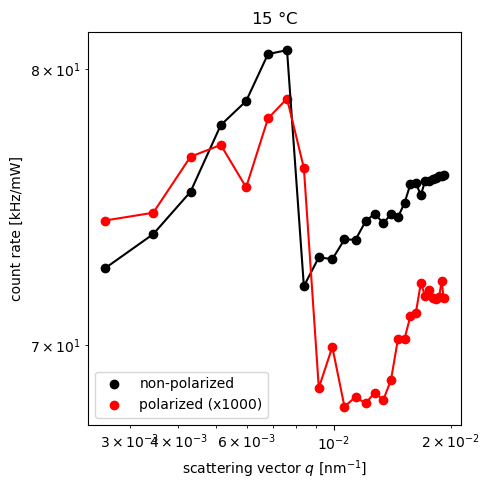

In [280]:
subset_15C_1 = data15Ccombined[::3]
subset_15C_2 = data15Ccombined[2::3]
correction = np.ones(len(subset_15C_1)) * 1500
correction[-8] *= 0.6

angles = 4 * np.pi * (1/632.8) * np.sin(np.deg2rad(subset_15C_1['Scattering angle [deg]'])/2)
# subset1_popt, subset1_pcov = curve_fit(exp, angles[-4::], (subset1['Scaled count rate [kHz/mW]'] * correction)[-4::], p0=[0,0,0])

fig = plt.figure(figsize=(5, 5))
plt.scatter(angles, subset_15C_2['Scaled count rate [kHz/mW]'], color='k', label='non-polarized')
plt.plot(angles, subset_15C_2['Scaled count rate [kHz/mW]'], color='k')

plt.scatter(angles, subset_15C_1['Scaled count rate [kHz/mW]'] * correction, color='r', label='polarized (x1000)')
plt.plot(angles, subset_15C_1['Scaled count rate [kHz/mW]'] * correction, color='r')

plt.xlabel('scattering vector $q$ [nm$^{-1}$]')
plt.xscale('log')
plt.ylabel('count rate [kHz/mW]')
plt.yscale('log')
plt.legend()
plt.title(r'15 $\degree$C')
plt.tight_layout()

plt.savefig(savedir + "SISV_guinier_15C.png")
plt.show()

In [302]:
temp = temps[1]
keys = pct_data.samples[temp]['experiments'].keys()
keys_isotropic = np.array(list(keys))[2::3]
keys_polarized = np.array(list(keys))[::3]

gammas = np.ones((len(keys_isotropic), 5, 2))
gammas_pol = np.ones((len(keys_polarized), 5, 2))

for i, k in enumerate(keys_isotropic):
    for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
        gamma = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
        
        gamma_nan = np.argmax(pd.isnull(gamma))
        gamma_lim = np.min((gamma_nan,2))
        gammas[i, ii,  :] = gamma[:gamma_lim]


for i, k in enumerate(keys_polarized):
        for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
            gamma_pol = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
            
            gamma_pol_nan = np.argmax(pd.isnull(gamma_pol))
            gamma_lim = np.min((gamma_nan,2))
            gammas_pol[i, ii,  :] = gamma_pol[:gamma_lim]

In [323]:
g_mean = np.mean(np.sort(gammas, axis=-1), axis=1)
g_pol_mean = np.mean(np.sort(gammas_pol, axis=-1), axis=1)
g_std = np.std(np.sort(gammas, axis=-1), axis=1)
g_pol_std = np.std(np.sort(gammas_pol, axis=-1), axis=1)

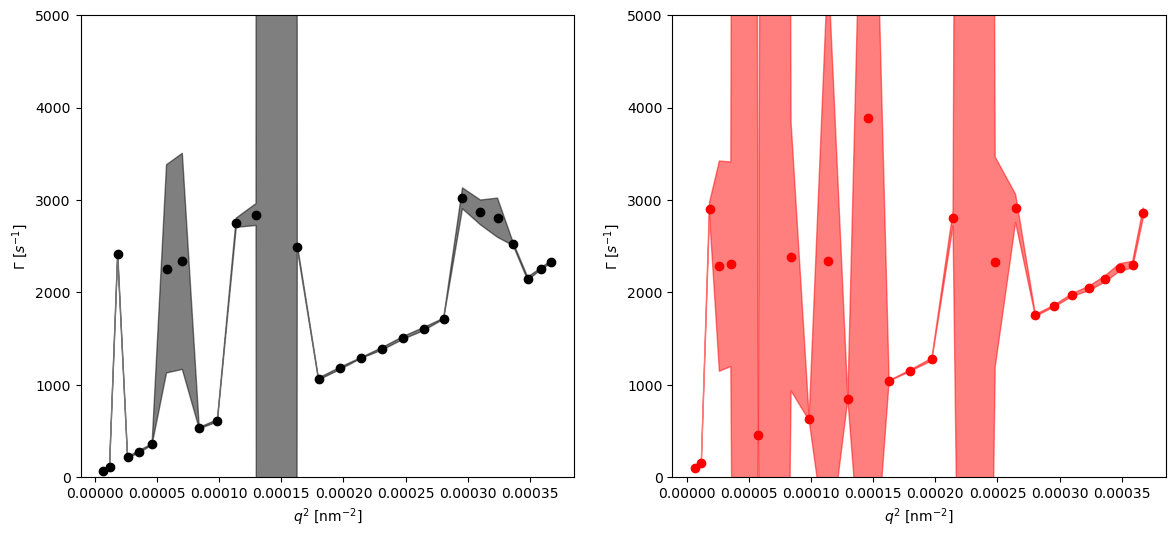

In [331]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
ax1, ax2 = axs

ax1.scatter((angles**2), g_mean[:,0], color='k')
ax1.fill_between(angles**2, g_mean[:,0] - g_std[:,0], g_mean[:,0] + g_std[:,0], color='k', alpha=0.5)
ax1.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax1.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax1.set_ylim([0,5000])

ax2.scatter(angles**2, g_pol_mean[:-1,0], color='r')
ax2.fill_between(angles**2, g_pol_mean[:-1,0] - g_pol_std[:-1,0], g_pol_mean[:-1,0] + g_pol_std[:-1,0], color='r', alpha=0.5)
ax2.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax2.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax2.set_ylim([0,5000])

plt.show()

In [340]:
idxs = np.ones(len(angles), dtype=bool)
idxs_pol = np.ones(len(angles), dtype=bool)

ransac15C = RANSACRegressor()
ransac15C_pol = RANSACRegressor()
ransac15C.fit(np.array(angles**2).reshape(-1, 1), g_mean[:, 0])
ransac15C_pol.fit(np.array(angles**2).reshape(-1, 1), g_pol_mean[:-1, 0])
D_15C = ransac15C.estimator_.coef_ * 10**(-18)
D_15C_pol = ransac15C_pol.estimator_.coef_ * 10**(-18)
print(D_15C, D_15C_pol)

[6.64901758e-12] [6.51562299e-12]


In [342]:
path18 = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/LDRD_FY25/data/SISV_1%/18.5C'
data18 = pd.read_csv(path18 + '/SISV_1%_18.5C.csv', skiprows=3)

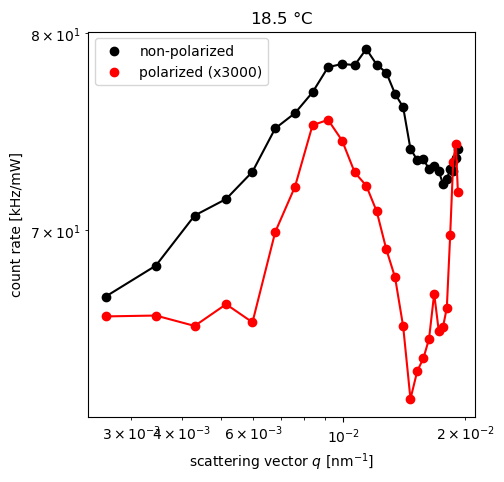

In [345]:
subset_18C_1 = data18[::3]
subset_18C_2 = data18[2::3]
correction = np.ones(len(subset_18C_1)) * 3000
correction[-8] *= 5/7.4
correction[-9] *= 1.03
correction[-11] *= 1.01

subset1_popt, subset1_pcov = curve_fit(exp, angles[-5::], (subset_18C_1['Scaled count rate [kHz/mW]'] * correction)[-5::], p0=[1,1,1])

fig = plt.figure(figsize=(5, 5))
plt.scatter(angles, subset_18C_2['Scaled count rate [kHz/mW]'], color='k', label='non-polarized')
plt.plot(angles, subset_18C_2['Scaled count rate [kHz/mW]'], color='k')

plt.scatter(angles, subset_18C_1['Scaled count rate [kHz/mW]']*correction - exp(angles, *subset1_popt) + 66, color='r', label='polarized (x3000)')
plt.plot(angles, subset_18C_1['Scaled count rate [kHz/mW]']*correction - exp(angles, *subset1_popt) + 66, color='r')

plt.xlabel('scattering vector $q$ [nm$^{-1}$]')
plt.xscale('log')
plt.ylabel('count rate [kHz/mW]')
plt.yscale('log')
plt.legend()
plt.title(r'18.5 $\degree$C')


plt.savefig(savedir + "SISV_guinier_18C.png")
plt.show()

In [361]:
temp = temps[2]
keys = pct_data.samples[temp]['experiments'].keys()
keys_isotropic = np.array(list(keys))[2::3]
keys_polarized = np.array(list(keys))[::3]

gammas = np.ones((len(keys_isotropic), 5, 2))
gammas_pol = np.ones((len(keys_polarized), 5, 2))

for i, k in enumerate(keys_isotropic):
    for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
        gamma = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
        
        gamma_nan = np.argmax(pd.isnull(gamma))
        gamma_lim = np.min((gamma_nan,2))
        gammas[i, ii,  :] = gamma[:gamma_lim]


for i, k in enumerate(keys_polarized):
        for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
            gamma_pol = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
            
            gamma_pol_nan = np.argmax(pd.isnull(gamma_pol))
            gamma_lim = np.min((gamma_nan,2))
            gammas_pol[i, ii,  :] = gamma_pol[:gamma_lim]

In [362]:
g_mean = np.mean(np.sort(gammas, axis=-1), axis=1)
g_pol_mean = np.mean(np.sort(gammas_pol, axis=-1), axis=1)
g_std = np.std(np.sort(gammas, axis=-1), axis=1)
g_pol_std = np.std(np.sort(gammas_pol, axis=-1), axis=1)

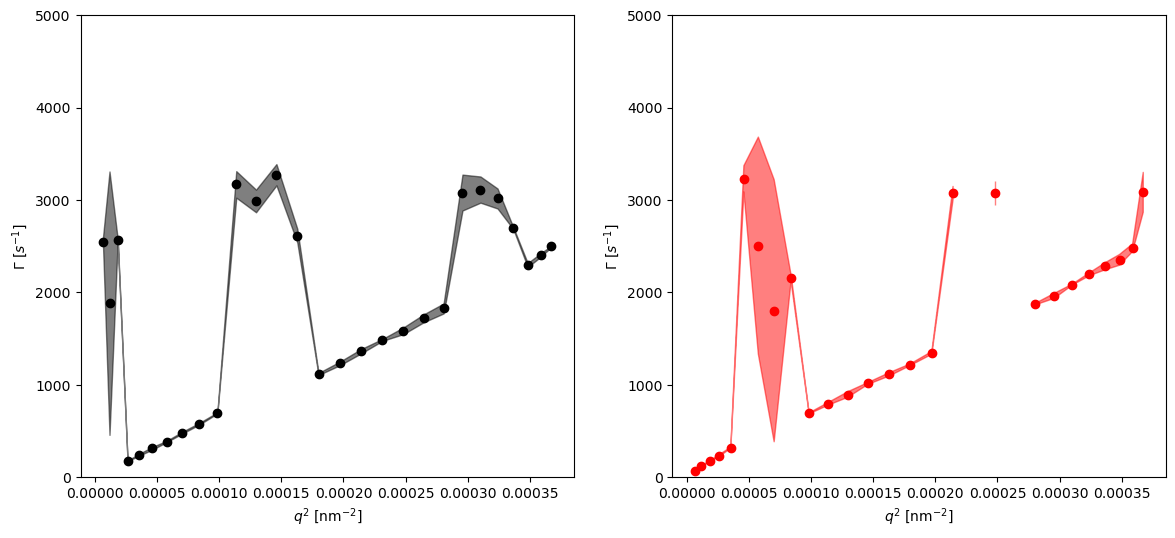

In [363]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
ax1, ax2 = axs

ax1.scatter((angles**2), g_mean[:,0], color='k')
ax1.fill_between(angles**2, g_mean[:,0] - g_std[:,0], g_mean[:,0] + g_std[:,0], color='k', alpha=0.5)
ax1.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax1.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax1.set_ylim([0,5000])

ax2.scatter(angles**2, g_pol_mean[:,0], color='r')
ax2.fill_between(angles**2, g_pol_mean[:,0] - g_pol_std[:,0], g_pol_mean[:,0] + g_pol_std[:,0], color='r', alpha=0.5)
ax2.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax2.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax2.set_ylim([0,5000])

plt.show()

In [364]:
idxs = np.ones(len(angles), dtype=bool)
idxs_pol = np.ones(len(angles), dtype=bool)

ransac18C = RANSACRegressor()
ransac18C_pol = RANSACRegressor()
ransac18C.fit(np.array(angles**2).reshape(-1, 1), g_mean[:, 0])
ransac18C_pol.fit(np.array(angles**2).reshape(-1, 1), np.nan_to_num(g_pol_mean[:, 0], nan=2000))
D_18C = ransac18C.estimator_.coef_ * 10**(-18)
D_18C_pol = ransac18C_pol.estimator_.coef_ * 10**(-18)
print(D_18C, D_18C_pol)

[7.8940225e-12] [7.04194416e-12]


In [365]:
path22 = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/LDRD_FY25/data/SISV_1%/22C'
data22 = pd.read_csv(path22 + '/SISV_MAPCS_1.csv', skiprows=3)

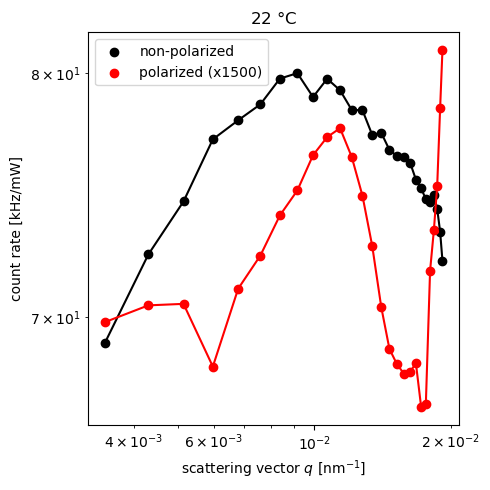

In [371]:
subset_22_1 = data22[::3]
subset_22_2 = data22[2::3]
correction = np.ones(len(subset_22_1)) * 1500
angles = 4 * np.pi * (1/632.8) * np.sin(np.deg2rad(subset_22_1['Scattering angle [deg]'])/2)
subset1_popt, subset1_pcov = curve_fit(exp, angles[-5::], (subset_22_1['Scaled count rate [kHz/mW]'] * correction)[-5::], p0=[0,0,0])

fig = plt.figure(figsize=(5, 5))
plt.scatter(angles, subset_22_2['Scaled count rate [kHz/mW]'], color='k', label='non-polarized')
plt.plot(angles, subset_22_2['Scaled count rate [kHz/mW]'], color='k')

plt.scatter(angles, subset_22_1['Scaled count rate [kHz/mW]'] * correction - exp(angles, *subset1_popt) + 70, color='r', label='polarized (x1500)')
plt.plot(angles, subset_22_1['Scaled count rate [kHz/mW]'] * correction - exp(angles, *subset1_popt) + 70, color='r')

plt.xlabel('scattering vector $q$ [nm$^{-1}$]')
plt.xscale('log')
plt.ylabel('count rate [kHz/mW]')
plt.yscale('log')
plt.legend()
plt.title(r'22 $\degree$C')
plt.tight_layout()

plt.savefig(savedir + "SISV_guinier_22C.png")
plt.show()

In [372]:
temp = temps[3]
keys = pct_data.samples[temp]['experiments'].keys()
keys_isotropic = np.array(list(keys))[2::3]
keys_polarized = np.array(list(keys))[::3]

gammas = np.ones((len(keys_isotropic), 5, 2))
gammas_pol = np.ones((len(keys_polarized), 5, 2))

for i, k in enumerate(keys_isotropic):
    for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
        gamma = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
        
        gamma_nan = np.argmax(pd.isnull(gamma))
        gamma_lim = np.min((gamma_nan,2))
        gammas[i, ii,  :] = gamma[:gamma_lim]


for i, k in enumerate(keys_polarized):
        for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
            gamma_pol = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
            
            gamma_pol_nan = np.argmax(pd.isnull(gamma_pol))
            gamma_lim = np.min((gamma_nan,2))
            gammas_pol[i, ii,  :] = gamma_pol[:gamma_lim]

In [373]:
g_mean = np.mean(np.sort(gammas, axis=-1), axis=1)
g_pol_mean = np.mean(np.sort(gammas_pol, axis=-1), axis=1)
g_std = np.std(np.sort(gammas, axis=-1), axis=1)
g_pol_std = np.std(np.sort(gammas_pol, axis=-1), axis=1)

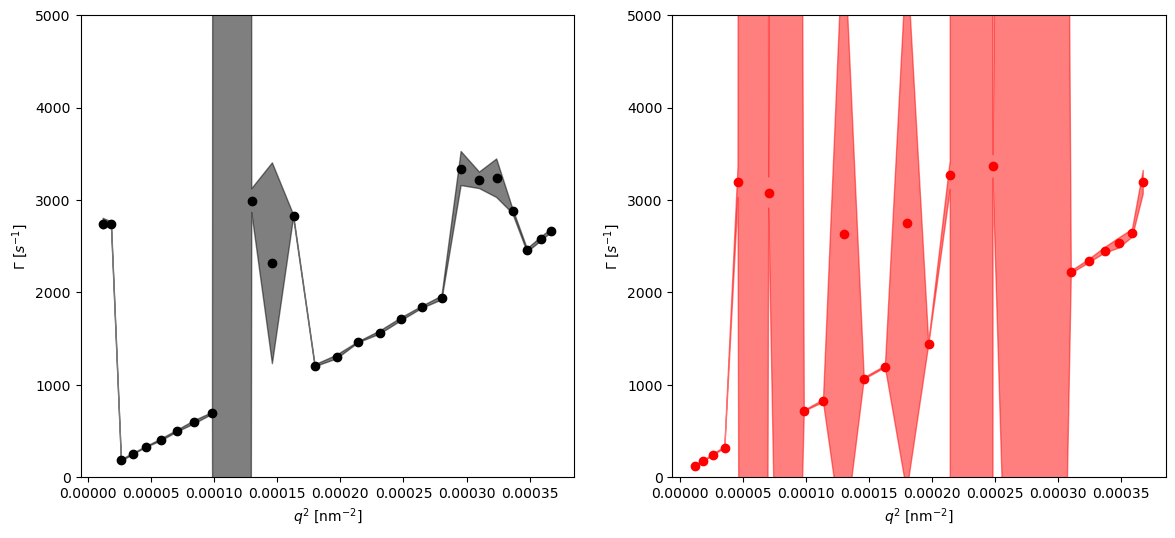

In [374]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
ax1, ax2 = axs

ax1.scatter((angles**2), g_mean[:,0], color='k')
ax1.fill_between(angles**2, g_mean[:,0] - g_std[:,0], g_mean[:,0] + g_std[:,0], color='k', alpha=0.5)
ax1.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax1.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax1.set_ylim([0,5000])

ax2.scatter(angles**2, g_pol_mean[:,0], color='r')
ax2.fill_between(angles**2, g_pol_mean[:,0] - g_pol_std[:,0], g_pol_mean[:,0] + g_pol_std[:,0], color='r', alpha=0.5)
ax2.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax2.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax2.set_ylim([0,5000])

plt.show()

In [375]:
idxs = np.ones(len(angles), dtype=bool)
idxs_pol = np.ones(len(angles), dtype=bool)

ransac22C = RANSACRegressor()
ransac22C_pol = RANSACRegressor()
ransac22C.fit(np.array(angles**2).reshape(-1, 1), g_mean[:, 0])
ransac22C_pol.fit(np.array(angles**2).reshape(-1, 1), np.nan_to_num(g_pol_mean[:, 0], nan=2000))
D_22C = ransac22C.estimator_.coef_ * 10**(-18)
D_22C_pol = ransac22C_pol.estimator_.coef_ * 10**(-18)
print(D_22C, D_22C_pol)

[8.47119057e-12] [7.44586639e-12]


In [376]:
path25 = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/LDRD_FY25/data/SISV_1%/25.5C'
data25 = pd.read_csv(path25 + '/7_3_2025 4_44_15 PM.csv', skiprows=3)

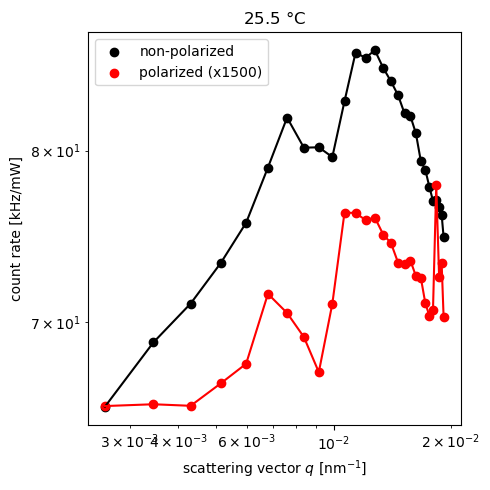

In [377]:
subset_25_1 = data25[:-2:3]
subset_25_2 = data25[2::3]
correction = np.ones(len(subset_25_1)) * 1500
correction[-8] *= 5/7.7
angles = 4 * np.pi * (1/632.8) * np.sin(np.deg2rad(subset_25_1['Scattering angle [deg]'])/2)
# subset1_popt, subset1_pcov = curve_fit(exp, angles[-3::], (subset1['Scaled count rate [kHz/mW]'] * correction)[-3::], p0=[1,1,1])

fig = plt.figure(figsize=(5, 5))
plt.scatter(angles, subset_25_2['Scaled count rate [kHz/mW]'], color='k', label='non-polarized')
plt.plot(angles, subset_25_2['Scaled count rate [kHz/mW]'], color='k')

plt.scatter(angles, subset_25_1['Scaled count rate [kHz/mW]'] * correction, color='r', label='polarized (x1500)')
plt.plot(angles, subset_25_1['Scaled count rate [kHz/mW]'] * correction, color='r')

plt.xlabel('scattering vector $q$ [nm$^{-1}$]')
plt.xscale('log')
plt.ylabel('count rate [kHz/mW]')
plt.yscale('log')
plt.legend()
plt.title(r'25.5 $\degree$C')
plt.tight_layout()

plt.savefig(savedir + "SISV_guinier_25C.png")
plt.show()

In [378]:
temp = temps[4]
keys = pct_data.samples[temp]['experiments'].keys()
keys_isotropic = np.array(list(keys))[2::3]
keys_polarized = np.array(list(keys))[::3]

gammas = np.ones((len(keys_isotropic), 5, 2))
gammas_pol = np.ones((len(keys_polarized), 5, 2))

for i, k in enumerate(keys_isotropic):
    for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
        gamma = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
        
        gamma_nan = np.argmax(pd.isnull(gamma))
        gamma_lim = np.min((gamma_nan,2))
        gammas[i, ii,  :] = gamma[:gamma_lim]


for i, k in enumerate(keys_polarized):
        for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
            gamma_pol = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
            
            gamma_pol_nan = np.argmax(pd.isnull(gamma_pol))
            gamma_lim = np.min((gamma_nan,2))
            gammas_pol[i, ii,  :] = gamma_pol[:gamma_lim]

In [379]:
g_mean = np.mean(np.sort(gammas, axis=-1), axis=1)
g_pol_mean = np.mean(np.sort(gammas_pol, axis=-1), axis=1)
g_std = np.std(np.sort(gammas, axis=-1), axis=1)
g_pol_std = np.std(np.sort(gammas_pol, axis=-1), axis=1)

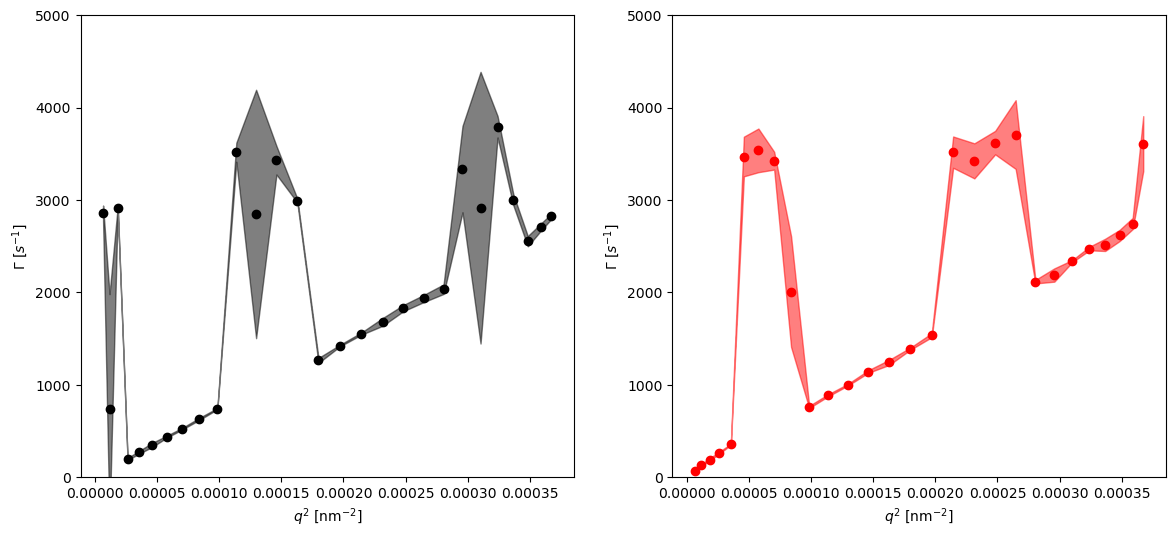

In [380]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
ax1, ax2 = axs

ax1.scatter((angles**2), g_mean[:,0], color='k')
ax1.fill_between(angles**2, g_mean[:,0] - g_std[:,0], g_mean[:,0] + g_std[:,0], color='k', alpha=0.5)
ax1.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax1.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax1.set_ylim([0,5000])

ax2.scatter(angles**2, g_pol_mean[:,0], color='r')
ax2.fill_between(angles**2, g_pol_mean[:,0] - g_pol_std[:,0], g_pol_mean[:,0] + g_pol_std[:,0], color='r', alpha=0.5)
ax2.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax2.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax2.set_ylim([0,5000])

plt.show()

In [381]:
idxs = np.ones(len(angles), dtype=bool)
idxs_pol = np.ones(len(angles), dtype=bool)

ransac25C = RANSACRegressor()
ransac25C_pol = RANSACRegressor()
ransac25C.fit(np.array(angles**2).reshape(-1, 1), g_mean[:, 0])
ransac25C_pol.fit(np.array(angles**2).reshape(-1, 1), np.nan_to_num(g_pol_mean[:, 0], nan=2000))
D_25C = ransac25C.estimator_.coef_ * 10**(-18)
D_25C_pol = ransac25C_pol.estimator_.coef_ * 10**(-18)
print(D_25C, D_25C_pol)

[7.5581262e-12] [7.46181769e-12]


In [385]:
path28 = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/LDRD_FY25/data/SISV_1%/28C'
data28 = pd.read_csv(path28 + '/SISV_1%_28C.csv', skiprows=3)

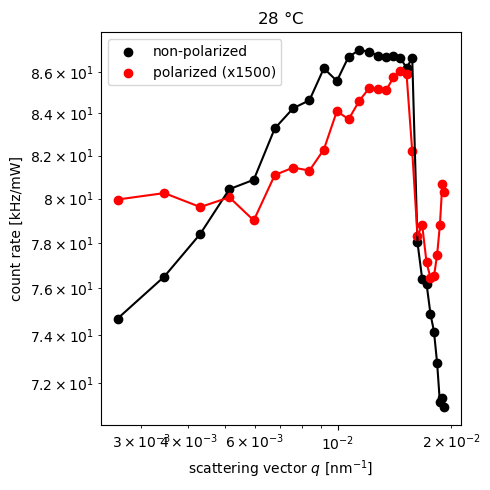

In [393]:
subset_28_1 = data28[::3]
subset_28_2 = data28[2::3]
correction = np.ones(len(subset_28_1)) * 1500
correction[-8] *= 5/7.3
 
subset1_popt, subset1_pcov = curve_fit(exp, angles[-6::], (subset_28_1['Scaled count rate [kHz/mW]'] * correction)[-6::], p0=[1,1,1])

fig = plt.figure(figsize=(5, 5))
plt.scatter(angles, subset_28_2['Scaled count rate [kHz/mW]'], color='k', label='non-polarized')
plt.plot(angles, subset_28_2['Scaled count rate [kHz/mW]'], color='k')

plt.scatter(angles, subset_28_1['Scaled count rate [kHz/mW]'] * correction - exp(angles, *subset1_popt) + 80, color='r', label='polarized (x1500)')
plt.plot(angles, subset_28_1['Scaled count rate [kHz/mW]'] * correction - exp(angles, *subset1_popt) + 80, color='r')

plt.xlabel('scattering vector $q$ [nm$^{-1}$]')
plt.xscale('log')
plt.ylabel('count rate [kHz/mW]')
plt.yscale('log')
plt.legend()
plt.title(r'28 $\degree$C')
plt.tight_layout()

plt.savefig(savedir + "SISV_guinier_28C.png")
plt.show()

In [407]:
temp = temps[5]
keys = pct_data.samples[temp]['experiments'].keys()
keys_isotropic = np.array(list(keys))[2::3]
keys_polarized = np.array(list(keys))[::3]

gammas = np.ones((len(keys_isotropic), 5, 2))
gammas_pol = np.ones((len(keys_polarized), 5, 2))

for i, k in enumerate(keys_isotropic):
    for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
        gamma = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
        gamma_nan = np.argmax(pd.isnull(gamma))
        gamma_lim = np.min((gamma_nan,2))
        if not gamma[:gamma_lim].empty:
            gammas[i, ii,  :] = gamma[:gamma_lim]
        


for i, k in enumerate(keys_polarized):
        for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
            gamma_pol = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
            
            gamma_pol_nan = np.argmax(pd.isnull(gamma_pol))
            gamma_lim = np.min((gamma_nan,2))
            gammas_pol[i, ii,  :] = gamma_pol[:gamma_lim]

In [408]:
g_mean = np.mean(np.sort(gammas, axis=-1), axis=1)
g_pol_mean = np.mean(np.sort(gammas_pol, axis=-1), axis=1)
g_std = np.std(np.sort(gammas, axis=-1), axis=1)
g_pol_std = np.std(np.sort(gammas_pol, axis=-1), axis=1)

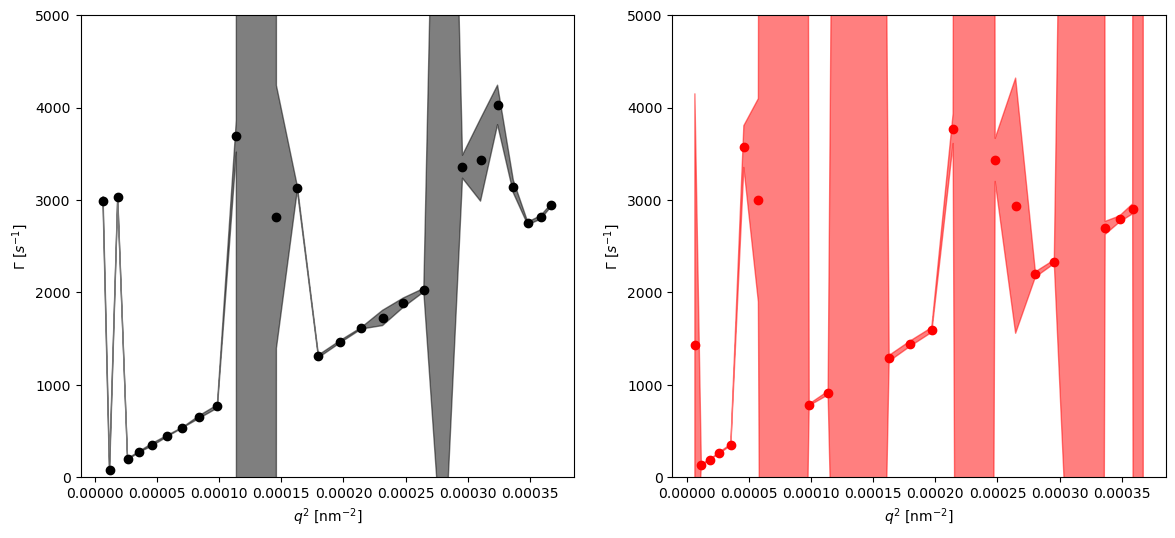

In [409]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
ax1, ax2 = axs

ax1.scatter((angles**2), g_mean[:,0], color='k')
ax1.fill_between(angles**2, g_mean[:,0] - g_std[:,0], g_mean[:,0] + g_std[:,0], color='k', alpha=0.5)
ax1.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax1.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax1.set_ylim([0,5000])

ax2.scatter(angles**2, g_pol_mean[:,0], color='r')
ax2.fill_between(angles**2, g_pol_mean[:,0] - g_pol_std[:,0], g_pol_mean[:,0] + g_pol_std[:,0], color='r', alpha=0.5)
ax2.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax2.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax2.set_ylim([0,5000])

plt.show()

In [410]:
idxs = np.ones(len(angles), dtype=bool)
idxs_pol = np.ones(len(angles), dtype=bool)

ransac28C = RANSACRegressor()
ransac28C_pol = RANSACRegressor()
ransac28C.fit(np.array(angles**2).reshape(-1, 1), g_mean[:, 0])
ransac28C_pol.fit(np.array(angles**2).reshape(-1, 1), np.nan_to_num(g_pol_mean[:, 0], nan=2000))
D_28C = ransac28C.estimator_.coef_ * 10**(-18)
D_28C_pol = ransac28C_pol.estimator_.coef_ * 10**(-18)
print(D_28C, D_28C_pol)

[8.17455806e-12] [7.02780398e-12]


In [411]:
path30 = '/Users/mwhittaker/Library/CloudStorage/GoogleDrive-mwhittaker@lbl.gov/My Drive/LDRD_FY25/data/SISV_1%/30.5C'
data30 = pd.read_csv(path30 + '/SISV_1%_30.5C.csv', skiprows=3)

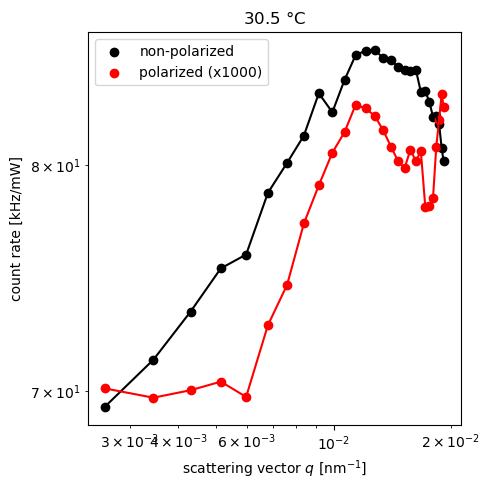

In [412]:
subset_30_1 = data30[::3]
subset_30_2 = data30[2::3]
correction = np.ones(len(subset_30_1)) * 1000

subset1_popt, subset1_pcov = curve_fit(exp, angles[-5::], (subset_30_1['Scaled count rate [kHz/mW]'] * correction)[-5::], p0=[1,1,1])

fig = plt.figure(figsize=(5, 5))
plt.scatter(angles, subset_30_2['Scaled count rate [kHz/mW]'], color='k', label='non-polarized')
plt.plot(angles, subset_30_2['Scaled count rate [kHz/mW]'], color='k')

plt.scatter(angles, subset_30_1['Scaled count rate [kHz/mW]']*correction - exp(angles, *subset1_popt) + 70, color='r', label='polarized (x1000)')
plt.plot(angles, subset_30_1['Scaled count rate [kHz/mW]']*correction - exp(angles, *subset1_popt) + 70, color='r')

plt.xlabel('scattering vector $q$ [nm$^{-1}$]')
plt.xscale('log')
plt.ylabel('count rate [kHz/mW]')
plt.yscale('log')
plt.legend()
plt.title(r'30.5 $\degree$C')
plt.tight_layout()

plt.savefig(savedir + "SISV_guinier_30C.png")
plt.show()

In [413]:
temp = temps[6]
keys = pct_data.samples[temp]['experiments'].keys()
keys_isotropic = np.array(list(keys))[2::3]
keys_polarized = np.array(list(keys))[::3]

gammas = np.ones((len(keys_isotropic), 5, 2))
gammas_pol = np.ones((len(keys_polarized), 5, 2))

for i, k in enumerate(keys_isotropic):
    for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
        gamma = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
        gamma_nan = np.argmax(pd.isnull(gamma))
        gamma_lim = np.min((gamma_nan,2))
        if not gamma[:gamma_lim].empty:
            gammas[i, ii,  :] = gamma[:gamma_lim]
        


for i, k in enumerate(keys_polarized):
        for ii, m in enumerate(pct_data.samples[temp]['experiments'][k]['measurements'].keys()):
            gamma_pol = pct_data.samples[temp]['experiments'][k]['measurements'][m]['repetitions']['CORENN Gamma Results.csv']['Average [nm]']
            
            gamma_pol_nan = np.argmax(pd.isnull(gamma_pol))
            gamma_lim = np.min((gamma_nan,2))
            gammas_pol[i, ii,  :] = gamma_pol[:gamma_lim]

In [414]:
g_mean = np.mean(np.sort(gammas, axis=-1), axis=1)
g_pol_mean = np.mean(np.sort(gammas_pol, axis=-1), axis=1)
g_std = np.std(np.sort(gammas, axis=-1), axis=1)
g_pol_std = np.std(np.sort(gammas_pol, axis=-1), axis=1)

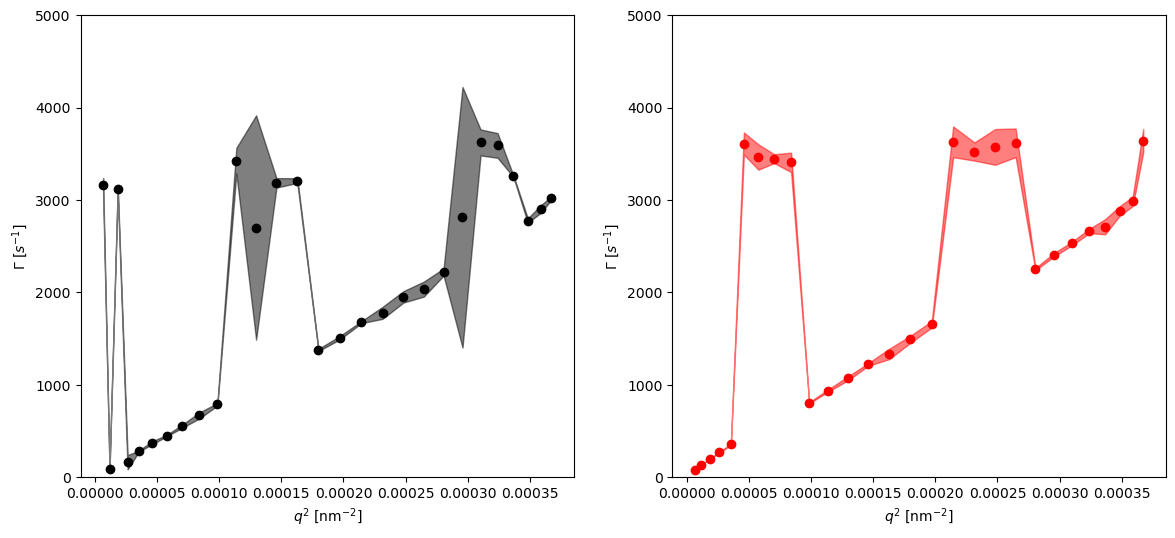

In [415]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
ax1, ax2 = axs

ax1.scatter((angles**2), g_mean[:,0], color='k')
ax1.fill_between(angles**2, g_mean[:,0] - g_std[:,0], g_mean[:,0] + g_std[:,0], color='k', alpha=0.5)
ax1.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax1.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax1.set_ylim([0,5000])

ax2.scatter(angles**2, g_pol_mean[:,0], color='r')
ax2.fill_between(angles**2, g_pol_mean[:,0] - g_pol_std[:,0], g_pol_mean[:,0] + g_pol_std[:,0], color='r', alpha=0.5)
ax2.set_xlabel(r'$q^2$ [nm$^{-2}$]')
ax2.set_ylabel(r'$\Gamma$ [$s^{-1}]$')
ax2.set_ylim([0,5000])

plt.show()

In [421]:
idxs = np.ones(len(angles), dtype=bool)
idxs_pol = np.ones(len(angles), dtype=bool)

ransac30C = RANSACRegressor()
ransac30C_pol = RANSACRegressor()
ransac30C.fit(np.array(angles**2).reshape(-1, 1), g_mean[:, 0])
ransac30C_pol.fit(np.array(angles**2).reshape(-1, 1), np.nan_to_num(g_pol_mean[:, 0], nan=2000))
D_30C = ransac30C.estimator_.coef_ * 10**(-18)
D_30C_pol = ransac30C_pol.estimator_.coef_ * 10**(-18)
print(D_30C, D_30C_pol)

[8.88851456e-12] [8.4275396e-12]


In [443]:
D_iso = [D_11C, D_15C, D_18C, D_22C, D_25C, D_28C, D_30C]
D_aniso = [D_11C_pol, D_15C_pol, D_18C_pol, D_22C_pol, D_25C_pol, D_28C_pol*1.1, D_30C_pol]

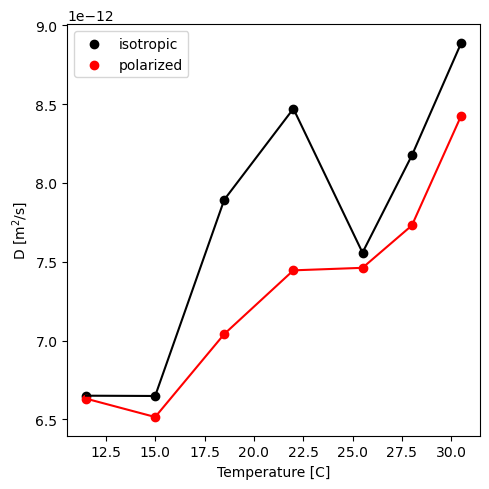

In [444]:
plt.figure(figsize=(5,5))
plt.scatter(temps, D_iso, label='isotropic', color='k')
plt.plot(temps, D_iso, color='k')
plt.scatter(temps, D_aniso, label='polarized', color='r')
plt.plot(temps, D_aniso, color='r')
plt.legend()

plt.xlabel('Temperature [C]')
plt.ylabel(r'D [m$^2$/s]')

plt.tight_layout()
plt.savefig(savedir + "SISV_D.png")

plt.show()

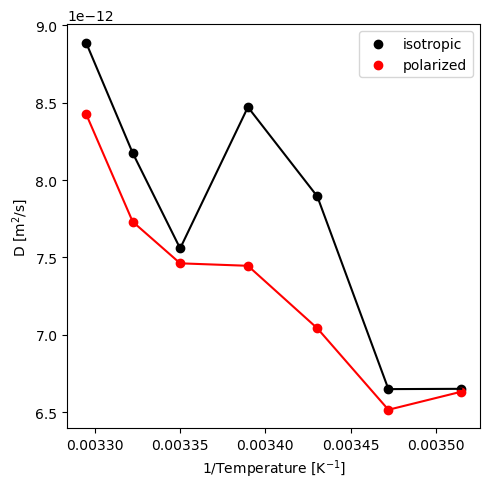

In [445]:
plt.figure(figsize=(5,5))
plt.scatter(1/(temps+273), D_iso, label='isotropic', color='k')
plt.plot(1/(temps+273), D_iso, color='k')
plt.scatter(1/(temps+273), D_aniso, label='polarized', color='r')
plt.plot(1/(temps+273), D_aniso, color='r')
plt.legend()

plt.xlabel('1/Temperature [K$^{-1}$]')
plt.ylabel(r'D [m$^2$/s]')

plt.tight_layout()
plt.savefig(savedir + "SISV_D_Ea.png")

plt.show()

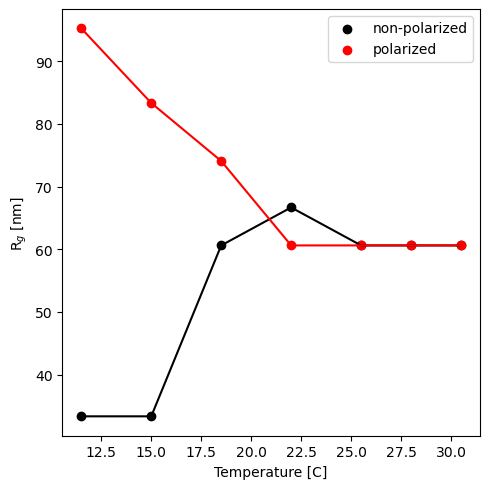

In [436]:
temps = np.array([11.5, 15, 18.5, 22, 25.5, 28, 30.5])
R_gs = 2/3 * 1/np.array([2e-2, 2e-2, 1.1e-2, 1e-2, 1.1e-2, 1.1e-2, 1.1e-2])
R_gps = 2/3 * 1/np.array([7e-3, 8e-3, 9e-3, 1.1e-2, 1.1e-2, 1.1e-2, 1.1e-2])

fig = plt.figure(figsize=(5, 5))
plt.scatter(temps, R_gs, color='k', label='non-polarized')
plt.plot(temps, R_gs, color='k')

plt.scatter(temps, R_gps, color='r', label='polarized')
plt.plot(temps, R_gps, color='r')

plt.xlabel('Temperature [C]')
plt.ylabel('R$_g$ [nm]')

plt.legend()
plt.tight_layout()

plt.savefig(savedir + "SISV_Rg.png")
plt.show()

In [429]:
R_gs

array([33.33333333, 33.33333333, 60.60606061, 66.66666667, 60.60606061,
       60.60606061, 60.60606061])